# Bar-chart-race

In [1]:
import os
import pycountry # https://pypi.org/project/pycountry/
import requests
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader import wb

## Flourish Flags (215 countries)
Same as WDI, only that WDI has Kosovo (XKX) and Channel Islands (CHI)

In [2]:
flags = pd.read_csv('flourish-flags-215/flourish-flags-215-input.csv')
flags["alpha_2"] = flags["Image URL"].str.split(pat="/",expand=True)[5].map(lambda x: x.replace('.svg',''))
flags["alpha_3"] = flags["alpha_2"].map(lambda x: pycountry.countries.get(alpha_2=x).alpha_3)
flags["Country"] = flags["alpha_2"].map(lambda x: pycountry.countries.get(alpha_2=x).name)
ids = {'Long':['Antigua and Barbuda', 'Bahamas, The', 'Bosnia and Herzegovina', 'British Virgin Islands', 'Brunei Darussalam', 'Central African Republic', 'Congo, Dem. Rep.', 'Dominican Republic', 'Egypt, Arab Rep.', 'Equatorial Guinea', 'French Polynesia', 'Gambia, The', 'Hong Kong SAR, China', 'Iran, Islamic Rep.', "Korea, Dem. People’s Rep.", "Korea, Rep.", 'Macao SAR, China', 'Micronesia, Fed. Sts.', 'Northern Mariana Islands', 'Sao Tome and Principe', 'Sint Maarten (Dutch part)', 'Solomon Islands', 'St. Kitts and Nevis', 'St. Martin (French part)', 'St. Vincent and the Grenadines', 'Syrian Arab Republic', 'Trinidad and Tobago', 'Turks and Caicos Islands', 'Virgin Islands (U.S.)', 'West Bank and Gaza', 'Yemen, Rep.'],
      'Short':['Antigua and B.', 'Bahamas', 'Bosnia and H.', 'Brit. Virgin Is', 'Brunei', 'CAR', 'Congo', 'Dominican Rep.', 'Egypt', 'Eq. Guinea', 'Fr. Polynesia', 'Gambia', 'Hong Kong', 'Iran', 'North Korea', 'South Korea', 'Macao', 'Micronesia', 'N. Mariana Is.', 'Sao Tome & P.', 'Sint M. (Dutch)', 'Solomon Is.', 'St. Kitts & N.', 'St. Martin (Fr.)', 'St. Vincent &.', 'Syria', 'Trinidad and T.', 'Turks & C. Is.', 'Vir. Islands', 'West Bank & G.', 'Yemen']}
shortnames = dict(zip(ids['Long'], ids['Short'])) 
flags["Country_short"] = flags["Country Name"].replace(shortnames)
flags.to_csv('flourish-flags-215/flourish-flags-215-output.csv')
flags

,Country Name,Region,Image URL,alpha_2,alpha_3,Country,Country_short
0,Afghanistan,Asia,https://public.flourish.studio/country-flags/s...,af,AFG,Afghanistan,Afghanistan
1,Albania,Europe,https://public.flourish.studio/country-flags/s...,al,ALB,Albania,Albania
2,Algeria,Africa,https://public.flourish.studio/country-flags/s...,dz,DZA,Algeria,Algeria
3,American Samoa,Oceania,https://public.flourish.studio/country-flags/s...,as,ASM,American Samoa,American Samoa
4,Andorra,Europe,https://public.flourish.studio/country-flags/s...,ad,AND,Andorra,Andorra
...,...,...,...,...,...,...,...
210,Virgin Islands (U.S.),Americas,https://public.flourish.studio/country-flags/s...,vi,VIR,"Virgin Islands, U.S.",Vir. Islands
211,West Bank and Gaza,Asia,https://public.flourish.studio/country-flags/s...,ps,PSE,"Palestine, State of",West Bank & G.
212,"Yemen, Rep.",Asia,https://public.flourish.studio/country-flags/s...,ye,YEM,Yemen,Yemen
213,Zambia,Africa,https://public.flourish.studio/country-flags/s...,zm,ZMB,Zambia,Zambia


In [3]:
pd.DataFrame([shortnames])

,Antigua and Barbuda,"Bahamas, The",Bosnia and Herzegovina,British Virgin Islands,Brunei Darussalam,Central African Republic,"Congo, Dem. Rep.",Dominican Republic,"Egypt, Arab Rep.",Equatorial Guinea,French Polynesia,"Gambia, The","Hong Kong SAR, China","Iran, Islamic Rep.","Korea, Dem. People’s Rep.","Korea, Rep.","Macao SAR, China","Micronesia, Fed. Sts.",Northern Mariana Islands,Sao Tome and Principe,Sint Maarten (Dutch part),Solomon Islands,St. Kitts and Nevis,St. Martin (French part),St. Vincent and the Grenadines,Syrian Arab Republic,Trinidad and Tobago,Turks and Caicos Islands,Virgin Islands (U.S.),West Bank and Gaza,"Yemen, Rep."
0,Antigua and B.,Bahamas,Bosnia and H.,Brit. Virgin Is,Brunei,CAR,Congo,Dominican Rep.,Egypt,Eq. Guinea,Fr. Polynesia,Gambia,Hong Kong,Iran,North Korea,South Korea,Macao,Micronesia,N. Mariana Is.,Sao Tome & P.,Sint M. (Dutch),Solomon Is.,St. Kitts & N.,St. Martin (Fr.),St. Vincent &.,Syria,Trinidad and T.,Turks & C. Is.,Vir. Islands,West Bank & G.,Yemen


## Loop through 215 countries and download all data from CAIT

In [4]:
df_full = pd.DataFrame()
exceptions = []
for count, (iso, country) in enumerate(zip(flags["alpha_3"], flags["Country"])):
    print(count, iso, country)
    try:
        df_country = pd.DataFrame()
        r = requests.get('https://www.climatewatchdata.org/api/v1/data/historical_emissions?regions=%s'%iso)
        x = r.json()
        df = pd.DataFrame(x['data'])
        df = df[df.data_source=='CAIT']
        for i in df.index:
            temp = df[i:i+1]
            dict_em = temp['emissions'][i]
            num = len(dict_em)
            temp = temp.drop('emissions',axis=1)
            newdf = pd.DataFrame(np.repeat(temp.values,num,axis=0))
            newdf.columns = temp.columns
            newdf[['year','value']] = pd.DataFrame(dict_em)
            df_country = df_country.append(newdf)
        df_full = df_full.append(df_country)
    except:
        print("An exception occurred")
        exceptions.append(country)

0 AFG Afghanistan
1 ALB Albania
2 DZA Algeria
3 ASM American Samoa
An exception occurred
4 AND Andorra
5 AGO Angola
6 ATG Antigua and Barbuda
7 ARG Argentina
8 ARM Armenia
9 ABW Aruba
10 AUS Australia
11 AUT Austria
12 AZE Azerbaijan
13 BHS Bahamas
14 BHR Bahrain
15 BGD Bangladesh
16 BRB Barbados
17 BLR Belarus
18 BEL Belgium
19 BLZ Belize
20 BEN Benin
21 BMU Bermuda
An exception occurred
22 BTN Bhutan
23 BOL Bolivia, Plurinational State of
24 BIH Bosnia and Herzegovina
25 BWA Botswana
26 BRA Brazil
27 VGB Virgin Islands, British
28 BRN Brunei Darussalam
29 BGR Bulgaria
30 BFA Burkina Faso
31 BDI Burundi
32 CPV Cabo Verde
33 KHM Cambodia
34 CMR Cameroon
35 CAN Canada
36 CYM Cayman Islands
An exception occurred
37 CAF Central African Republic
38 TCD Chad
39 CHL Chile
40 CHN China
41 COL Colombia
42 COM Comoros
43 COD Congo, The Democratic Republic of the
44 COG Congo
45 CRI Costa Rica
46 CIV Côte d'Ivoire
47 HRV Croatia
48 CUB Cuba
49 CUW Curaçao
An exception occurred
50 CYP Cyprus
51 C

In [5]:
np.array(exceptions)

array(['American Samoa', 'Bermuda', 'Cayman Islands', 'Curaçao',
       'Faroe Islands', 'French Polynesia', 'Gibraltar', 'Greenland',
       'Guam', 'Isle of Man', 'New Caledonia', 'Northern Mariana Islands',
       'Puerto Rico', 'Sint Maarten (Dutch part)',
       'Saint Martin (French part)', 'Virgin Islands, U.S.'], dtype='<U26')

## Keep All GHG Total excluding LUCF


In [6]:
totalLong = df_full[(df_full['sector'] == 'Total excluding LUCF') & (df_full['gas'] == 'All GHG')]
totalWide = totalLong.pivot_table(index="iso_code3",columns='year',values='value').reset_index()
export = flags.merge(totalWide, left_on='alpha_3', right_on='iso_code3', how='outer')
#export.to_csv('flourish-flags-215/flourish_1.csv',index = False)
#export.to_excel("flourish-flags-215/flourish_1.xlsx", sheet_name='Total', index = False)  

In [7]:
ids = {'Long':['Bolivia', 'Brunei', "C√¥te d'Ivoire", 'Cape Verde', 'Czech Republic', 'Democratic Republic of the Congo', 'Iran', 'Laos', 'Macedonia', 'Micronesia', 'Moldova', 'North Korea', 'Republic of Congo', 'Russia', 'South Korea', 'Syria', 'Tanzania', 'Venezuela', 'Vietnam'],
      'Short':['Bolivia, Plurinational State of', 'Brunei Darussalam', "Côte d'Ivoire", 'Cabo Verde', 'Czechia', 'Congo, The Democratic Republic of the', 'Iran, Islamic Republic of', "Lao People's Democratic Republic", 'North Macedonia', 'Micronesia, Federated States of', 'Moldova, Republic of', "Korea, Democratic People's Republic of", 'Congo', 'Russian Federation', 'Korea, Republic of', 'Syrian Arab Republic', 'Tanzania, United Republic of', 'Venezuela, Bolivarian Republic of', 'Viet Nam']}
shortnames2 = dict(zip(ids['Long'], ids['Short'])) 
pd.DataFrame([shortnames2])

,Bolivia,Brunei,C√¥te d'Ivoire,Cape Verde,Czech Republic,Democratic Republic of the Congo,Iran,Laos,Macedonia,Micronesia,Moldova,North Korea,Republic of Congo,Russia,South Korea,Syria,Tanzania,Venezuela,Vietnam
0,"Bolivia, Plurinational State of",Brunei Darussalam,Côte d'Ivoire,Cabo Verde,Czechia,"Congo, The Democratic Republic of the","Iran, Islamic Republic of",Lao People's Democratic Republic,North Macedonia,"Micronesia, Federated States of","Moldova, Republic of","Korea, Democratic People's Republic of",Congo,Russian Federation,"Korea, Republic of",Syrian Arab Republic,"Tanzania, United Republic of","Venezuela, Bolivarian Republic of",Viet Nam


In [8]:
CAIT_1 = pd.read_excel('cait website/ghg-emissions.xlsx', sheet_name='Total')
CAIT_2 = pd.read_excel('cait website/ghg-emissions.xlsx', sheet_name='Per Capita')
CAIT_3 = pd.read_excel('cait website/ghg-emissions.xlsx', sheet_name='Per GDP')
CAIT_1["Country/Region"] = CAIT_1["Country/Region"].replace(shortnames2)
CAIT_2["Country/Region"] = CAIT_2["Country/Region"].replace(shortnames2)
CAIT_3["Country/Region"] = CAIT_3["Country/Region"].replace(shortnames2)

In [9]:
varss = ["Country Name", "Region", "Image URL", "alpha_2", "alpha_3", "Country", "Country_short", "iso_code3"]
export1 = export[varss].merge(CAIT_1, left_on='Country', right_on='Country/Region', how='left')
export2 = export[varss].merge(CAIT_2, left_on='Country', right_on='Country/Region', how='left')
export3 = export[varss].merge(CAIT_3, left_on='Country', right_on='Country/Region', how='left')

In [10]:
with pd.ExcelWriter('flourish-flags-215/flourish_1.xlsx') as writer:
    export.to_excel(writer, sheet_name='Total',index = False)
    export1.to_excel(writer, sheet_name='Total2',index = False)
    export2.to_excel(writer, sheet_name='Per Capita',index = False)
    export3.to_excel(writer, sheet_name='Per GDP',index = False)

# Inventory

In [11]:
df_full['variable'] = df_full['gas'] + ' - ' + df_full['sector']
Variables = list(df_full['variable'].unique())
len(Variables)

47

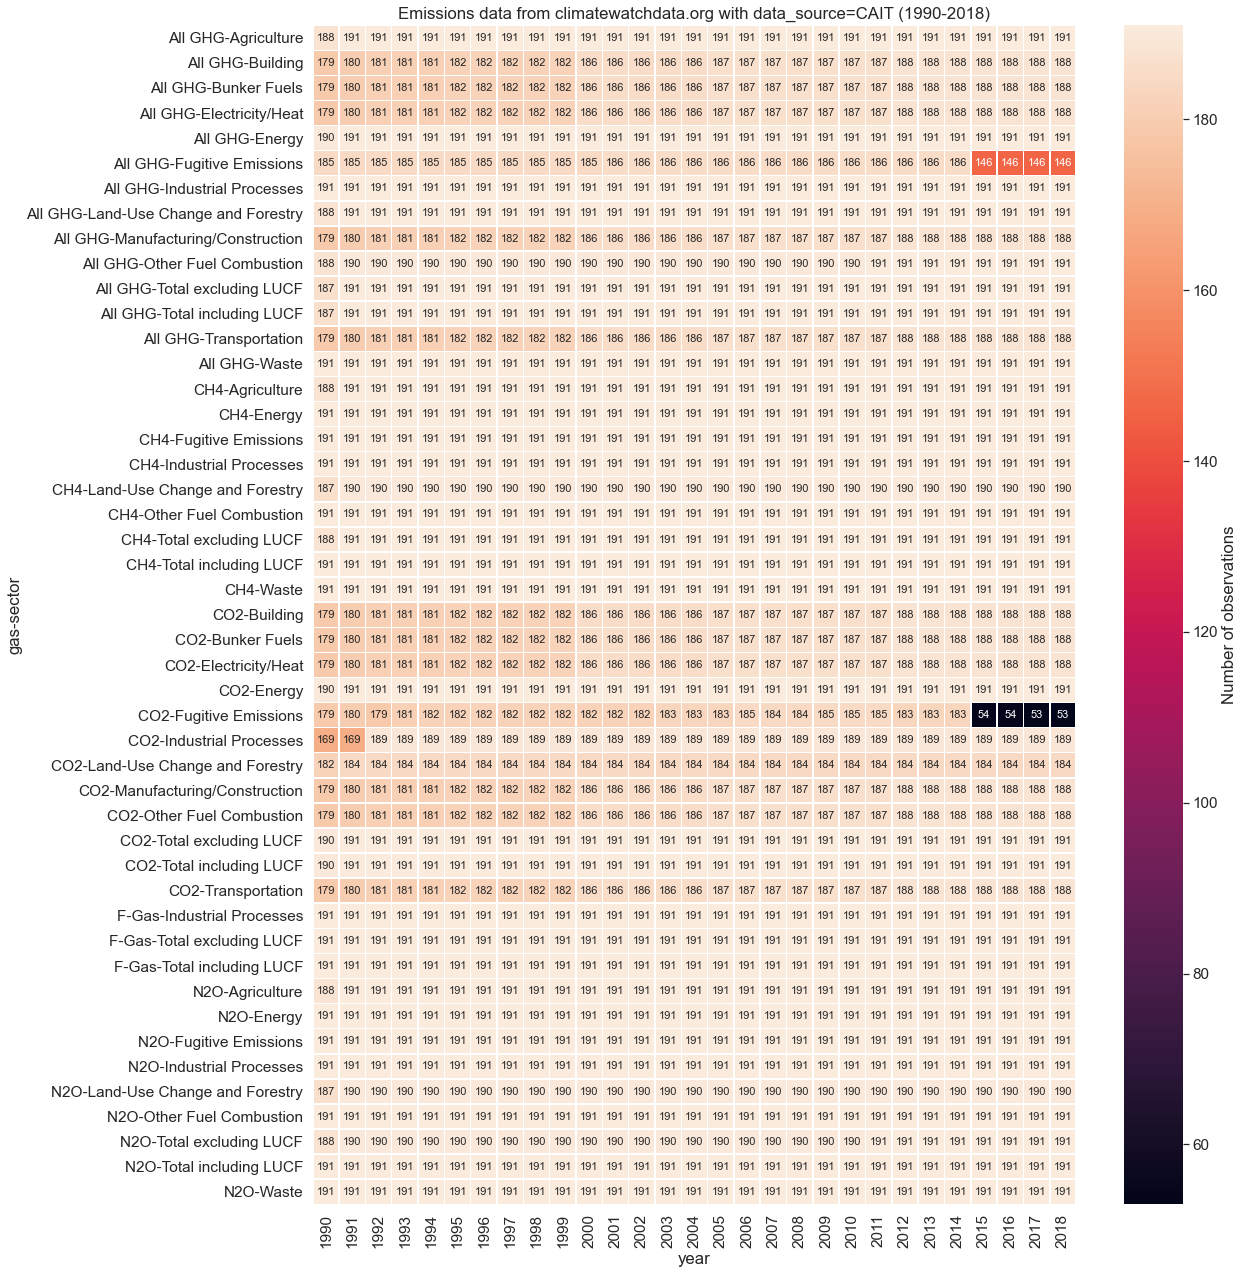

In [12]:
sns.set(font_scale=1.4)
piv = df_full.groupby(["gas", "sector", "year"])["value"].count().unstack()
fig, ax = plt.subplots(figsize=(18,18))         # Sample figsize in inches
sns.heatmap(piv,  ax=ax, annot=True, annot_kws={'fontsize': 11}, fmt="d", linewidth=.5, cbar_kws={'label': 'Number of observations'})
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
ax.set_title('Emissions data from climatewatchdata.org with data_source=CAIT (1990-2018)')
ax.set(facecolor="white")
plt.tight_layout()
plt.show()
fig.savefig('CAIT_Inventory.png')

Oct 1, 2021